In [65]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [66]:
batch_size = 64 # Batch size for training.
epochs = 100 # Number of epochs to train for.
latent_dim = 256 # Latent dimensionality of the encoding space.
num_samples = 4000 # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'cleaned_data.txt'
num_samples

4000

In [67]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    ind,input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 4000
Number of unique input tokens: 88
Number of unique output tokens: 108
Max sequence length for inputs: 164
Max sequence length for outputs: 155


In [68]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float16')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [69]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [70]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, 88)     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None, 108)    0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 256), (None, 353280      input_9[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, None, 256),  373760      input_10[0][0]                   
                                                                 lstm_7[0][1]                     
          

In [71]:
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/100
3200/3200 [==============================] - 106s 33ms/step - loss: 0.7208 - acc: 0.0435 - val_loss: 0.6854 - val_acc: 0.0393
Epoch 2/100
3200/3200 [==============================] - 102s 32ms/step - loss: 0.6663 - acc: 0.0402 - val_loss: 0.6325 - val_acc: 0.0497
Epoch 3/100
3200/3200 [==============================] - 99s 31ms/step - loss: 0.6084 - acc: 0.0559 - val_loss: 0.5806 - val_acc: 0.0592
Epoch 4/100
3200/3200 [==============================] - 98s 31ms/step - loss: 0.5624 - acc: 0.0638 - val_loss: 0.5424 - val_acc: 0.0676
Epoch 5/100
3200/3200 [==============================] - 97s 30ms/step - loss: 0.5284 - acc: 0.0717 - val_loss: 0.5051 - val_acc: 0.0776
Epoch 6/100
3200/3200 [==============================] - 97s 30ms/step - loss: 0.5000 - acc: 0.0778 - val_loss: 0.4847 - val_acc: 0.0799
Epoch 7/100
3200/3200 [==============================] - 97s 30ms/step - loss: 0.4810 - acc: 0.0809 - val_loss: 0.4690 - val_acc:

3200/3200 [==============================] - 97s 30ms/step - loss: 0.2588 - acc: 0.1334 - val_loss: 0.4272 - val_acc: 0.0995
Epoch 61/100
3200/3200 [==============================] - 97s 30ms/step - loss: 0.2390 - acc: 0.1386 - val_loss: 0.4312 - val_acc: 0.0988
Epoch 62/100
3200/3200 [==============================] - 98s 31ms/step - loss: 0.2316 - acc: 0.1407 - val_loss: 0.4333 - val_acc: 0.0984
Epoch 63/100
3200/3200 [==============================] - 97s 30ms/step - loss: 0.2281 - acc: 0.1417 - val_loss: 0.4390 - val_acc: 0.0985
Epoch 64/100
3200/3200 [==============================] - 98s 30ms/step - loss: 0.2241 - acc: 0.1427 - val_loss: 0.4413 - val_acc: 0.0981
Epoch 65/100
3200/3200 [==============================] - 97s 30ms/step - loss: 0.2212 - acc: 0.1437 - val_loss: 0.4445 - val_acc: 0.0983
Epoch 66/100
3200/3200 [==============================] - 97s 30ms/step - loss: 0.2218 - acc: 0.1436 - val_loss: 0.4463 - val_acc: 0.0973
Epoch 67/100
3200/3200 [=======================

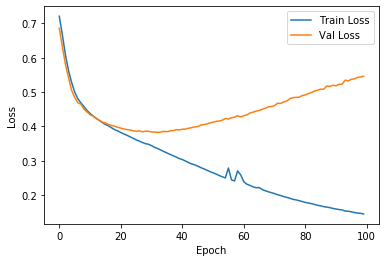

In [72]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, np.array(history.history['loss']),
               label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

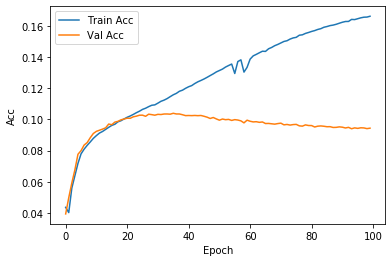

In [73]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.plot(history.epoch, np.array(history.history['acc']),
               label='Train Acc')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Acc')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

In [74]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [75]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [76]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [77]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: I do not want to die.
Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

-
Input sentence: It's the same country I think.
Decoded sentence: मैं तुम्हें पता था निक ला समय ली जावत है.

-
Input sentence: Then they'll be crying like babies.
Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

-
Input sentence: - No, I need power up!
Decoded sentence: - मैं तुम सो करोसे को रूप में प्रति कर दीता, तुम की रहे में पड़े सुकाने पता है तो बच्चाई की को माफ़ा था.

-
Input sentence: I will not eat him.
Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

-
Input sentence: You gotta get me to Charleston.
Decoded sentence: तुम मुझे साथ लेंगे?

-
Input sentence: - NO, HE'S NOT MY DAD.
Decoded sentence: - मैं तुम सो करोसे को रूप में प्रति कर दीता, तुम की रहे में पड़े सुकाने पता है तो बच्चाई की को माफ़ा था.

-
Input sentence: I told her we rest on Sundays.
Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

-
Input sentence: You could've at least informed me, right?
De

-
Input sentence: Come, Macedonians.
Decoded sentence: तुम मुझे साथ लेंगे?

-
Input sentence: How's her hair?
Decoded sentence: क्या तुम मुझे क्या करना चाहते हैं?

-
Input sentence: Hey, hey.
Decoded sentence: तुम मुझे साथ लेंगे?

-
Input sentence: Whoa! Astrid!
Decoded sentence: तुम मुझे साथ लेंगे?

-
Input sentence: Let's not repeat the same mistakes that we made in the past.
Decoded sentence: यह एक बच्चा है. हो!

-
Input sentence: Jack always told me that if anything should ever happened to him.
Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

-
Input sentence: I want you to come home.
Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

-
Input sentence: Carver just told me we're not gonna tell anybody what happened up there.
Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

-
Input sentence: Prove to us you are who you say you are.
Decoded sentence: क्या तुम मुझे क्या करना चाहते हैं?

-
Input sentence: The Spirit Realm.
Decoded sentence: यह एक बहु

In [78]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:',decoded_sentence)
    print('Individual 1-gram: %f' % sentence_bleu([target_sentence], decoded_sentence, weights=(1, 0, 0, 0)))
    print('Individual 2-gram: %f' % sentence_bleu([target_sentence], decoded_sentence, weights=(0, 1, 0, 0)))
    print('Individual 3-gram: %f' % sentence_bleu([target_sentence], decoded_sentence, weights=(0, 0, 1, 0)))
    print('Individual 4-gram: %f' % sentence_bleu([target_sentence], decoded_sentence, weights=(0, 0, 0, 1)))
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([target_sentence], decoded_sentence, weights =(0.25,0.25,0.25,0.25))
    print('4-gram cumm BLEU score:',BLEUscore)

-
Input sentence: I do not want to die.
Target sentence: 	मैं मरना नहीं चाहता.

Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

Individual 1-gram: 0.485714
Individual 2-gram: 0.235294
Individual 3-gram: 0.090909
Individual 4-gram: 0.031250
4-gram cumm BLEU score: 0.13423393480752616
-
Input sentence: It's the same country I think.
Target sentence: 	यह मुझे लगता है कि एक ही देश है.

Decoded sentence: मैं तुम्हें पता था निक ला समय ली जावत है.

Individual 1-gram: 0.571429
Individual 2-gram: 0.219512
Individual 3-gram: 0.100000
Individual 4-gram: 0.051282
4-gram cumm BLEU score: 0.15925625475624441
-
Input sentence: Then they'll be crying like babies.
Target sentence: 	फिर ये नन्हें बच्चों की तरह रोएँगे।

Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

Individual 1-gram: 0.468085
Individual 2-gram: 0.152174
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 7.70616801416754e-155


C:\Users\ryepu\.conda\envs\deeplearning\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\ryepu\.conda\envs\deeplearning\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


-
Input sentence: - No, I need power up!
Target sentence: 	नहीं, मुझे पावर की जरुरत है !

Decoded sentence: - मैं तुम सो करोसे को रूप में प्रति कर दीता, तुम की रहे में पड़े सुकाने पता है तो बच्चाई की को माफ़ा था.

Individual 1-gram: 0.247619
Individual 2-gram: 0.115385
Individual 3-gram: 0.048544
Individual 4-gram: 0.019608
4-gram cumm BLEU score: 0.07221437216022507
-
Input sentence: I will not eat him.
Target sentence: 	मैं उसे नहीं खा जाएगा.

Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

Individual 1-gram: 0.428571
Individual 2-gram: 0.235294
Individual 3-gram: 0.060606
Individual 4-gram: 0.031250
4-gram cumm BLEU score: 0.11755743200908036
-
Input sentence: You gotta get me to Charleston.
Target sentence: 	आप चार्ल्सटन करने के लिए मुझे जाना होगा.

Decoded sentence: तुम मुझे साथ लेंगे?

Individual 1-gram: 0.233010
Individual 2-gram: 0.105117
Individual 3-gram: 0.073971
Individual 4-gram: 0.058742
4-gram cumm BLEU score: 0.10156988182544098
-
Input sentence: - NO, HE'S NOT MY

-
Input sentence: Let's be real hot (nicer) I am of you
Target sentence: 	चलो तुम हो गरम रियल (अच्छे) का रहा हूँ मैं

Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

Individual 1-gram: 0.574468
Individual 2-gram: 0.195652
Individual 3-gram: 0.088889
Individual 4-gram: 0.045455
4-gram cumm BLEU score: 0.14598016331402125
-
Input sentence: Look, I know I quit the academy before.
Target sentence: 	मैं मैं पहले अकादमी छोड़ने पता है, देखो.

Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

Individual 1-gram: 0.468085
Individual 2-gram: 0.152174
Individual 3-gram: 0.022222
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 2.436123141043727e-78
-
Input sentence: We village elders still exist.
Target sentence: 	हम गांव के बुजुर्ग अभी भी मौजूद हैं.

Decoded sentence: मैं तुम्हें पता था निक ला समय ली जावत है.

Individual 1-gram: 0.571429
Individual 2-gram: 0.121951
Individual 3-gram: 0.025000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 2.49521593209797

C:\Users\ryepu\.conda\envs\deeplearning\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


-
Input sentence: Everybody, come on!
Target sentence: 	, वापस जाओ! ,

Decoded sentence: क्या तुम मुझे क्या करना चाहते हैं?

Individual 1-gram: 0.171429
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 1.1722739790570059e-231
-
Input sentence: For the lady!
Target sentence: 	महिला के लिए!

Decoded sentence: मैं तुम्हें पता था निक ला समय ली जावत है.

Individual 1-gram: 0.261905
Individual 2-gram: 0.073171
Individual 3-gram: 0.025000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 1.806929915871479e-78
-
Input sentence: Keep coming.
Target sentence: 	आते रहना.

Decoded sentence: मैं तुम्हें पता था निक ला समय ली जावत है.

Individual 1-gram: 0.190476
Individual 2-gram: 0.024390
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 3.8943629578389926e-155
-
Input sentence: I will find you!
Target sentence: 	मैं तुम्हें मिल जाएगा!

Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

Individual 1-gram: 

-
Input sentence: Carver just told me we're not gonna tell anybody what happened up there.
Target sentence: 	कार्वर ने बताया कि हमें उस घटना का ज़िक्र किसी से नहीं करना है।

Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

Individual 1-gram: 0.493237
Individual 2-gram: 0.207513
Individual 3-gram: 0.060607
Individual 4-gram: 0.015496
4-gram cumm BLEU score: 0.09901727490911837
-
Input sentence: Prove to us you are who you say you are.
Target sentence: 	हमें सिद्ध करो ... ... तुम जो कहते हो, वो हो.

Decoded sentence: क्या तुम मुझे क्या करना चाहते हैं?

Individual 1-gram: 0.425844
Individual 2-gram: 0.229622
Individual 3-gram: 0.150551
Individual 4-gram: 0.088717
4-gram cumm BLEU score: 0.19010293311581275
-
Input sentence: The Spirit Realm.
Target sentence: 	आत्मा मंडल।

Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

Individual 1-gram: 0.148936
Individual 2-gram: 0.021739
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 3